# Petermann xz Flowline Friction Inverse

Use the flowline created in PetermannFlowline_streamline-nc to run an inverse problem to solve for the basal friction that minimizes the misfit between the modeled and observed velocities

## Setup

In [4]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

/mnt/data01/Code/OtherRepos/firedrake/lib/python3.8/site-packages/pytools/__init__.py:2408: UserWarning: unable to find git revision
  warn("unable to find git revision")
fatal: detected dubious ownership in repository at '/mnt/data01/Code/OtherRepos/firedrake/src/PyOP2'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/data01/Code/OtherRepos/firedrake/src/PyOP2
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Mesh

In [5]:
flowline_fn = 'Petermann-centerline.nc'
flowline = xr.open_dataset(flowline_fn)

In [6]:
# Establish mesh, function spaces, and vector spaces that variables will live on in the mesh
ld=flowline['linedist'][0]
Lx = np.int(np.round(ld[-1]))
nx = np.int(np.round(ld[-1]/1000))

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

Q = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='R', vdegree=0
)

V = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='GL', vdegree=2
)

# Define spatial coordinates on the mesh
x, ζ = firedrake.SpatialCoordinate(mesh)

/tmp/ipykernel_265310/3767922216.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Lx = np.int(np.round(ld[-1]))
/tmp/ipykernel_265310/3767922216.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

### Load/Interpolate Raster Data

#### Reading Data
Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files
All files except BedMachine can be found [here](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing).
BedMachine and other file sources can be found here:
- [BedMachine](https://nsidc.org/data/idbmg4/versions/5)
- [MEaSUREs](https://nsidc.org/grimp)
- [Martos Geothermal heat flux](https://doi.pangaea.de/10.1594/PANGAEA.892973?format=html#download)
- [RACMO2 Surface Temperature/Surface Mass Balance](https://doi.org/10.5194/tc-10-2361-2016) (Need to email author Brice Noel for dataset)
- [Hillshade](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing) (creator is Nicholas Holchuh)


In [7]:
### Reading Data
### Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files

root_ddir = '/mnt/data01/Data/'

velocity_fn = glob.glob(root_ddir+'*vel*.nc')
ice_info_fn = glob.glob(root_ddir+'*BedMachine*.nc')
hillshade_fn = glob.glob(root_ddir+'*Hillshade*.nc') 
geothermal_fn = glob.glob(root_ddir+'*Martos*.nc')
racmo_fn = glob.glob(root_ddir+'*RACMO*.nc')

### Hillshade
hs = xr.open_dataset(hillshade_fn[0])

### Velocities
vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))
speed=np.sqrt(vx**2+vy**2)

### Glacial geometry
ice_bed_props = rxr.open_rasterio(ice_info_fn[0])
thickness = ice_bed_props['thickness'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]

### Climate forcings
geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000
racmo = xr.open_dataset(racmo_fn[0])
surftemp = racmo['T2m_avg']
SMB = racmo['SMB_avg']

### Get Petermann basin outline
outline_fn='petermann_streamlines_evenspace_full.geojson'
with open(outline_fn, 'r') as outline_file:
    basin_outline = geojson.load(outline_file)

basin_coords = []
for i in basin_outline['features'][0]['geometry']['coordinates']:
    for coord in i:
        basin_coords.append(coord)
basin_coords=np.array(basin_coords)

In [8]:
####### Here we interpolate onto the mesh
h0 = icepack.interpolate_xr(flowline['Thickness'], Q)
s0 = icepack.interpolate_xr(flowline['Surface'], Q)
b = icepack.interpolate_xr(flowline['Bed'], Q)
u0 = icepack.interpolate_xr(flowline['Speed'], V)

h_in = h0.at([0,0])
s_in = s0.at([0,0])
u_in = u0.at([0,0])
s_out = s0.at([Lx,0])

### Plotting Functions

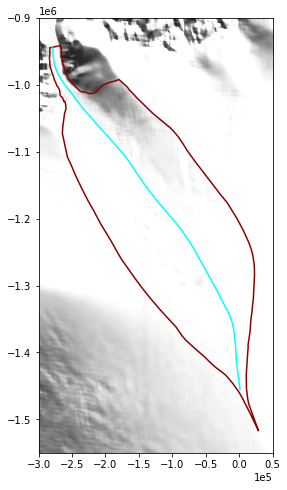

In [9]:
def basin_subplot(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    image = kwargs.get("image",0)
    fig, ax = plt.subplots(figsize=[8,8])
    im1=ax.imshow(hs['hillshade'].values,
                  extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],
                  cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.plot(basin_coords.T[0],basin_coords.T[1],c='darkred')
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

fig,ax = basin_subplot()
ax.plot(flowline['x_pol'][0],flowline['y_pol'][0],c='cyan');

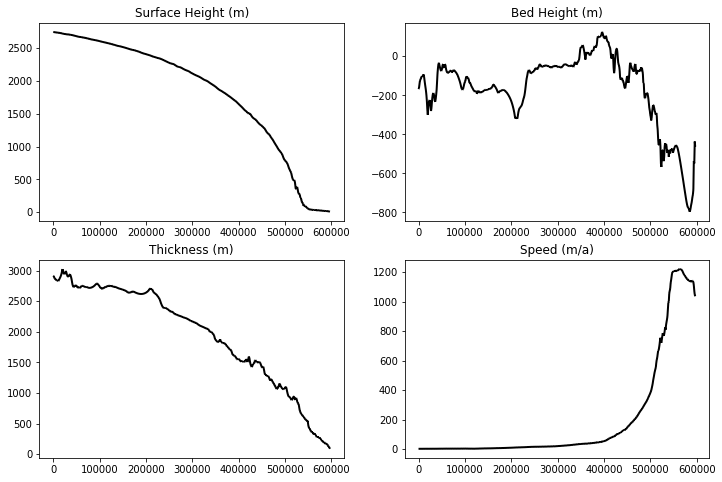

In [13]:
def depth_avg_plot(s0,h0,b,u0,**kwargs):
    figsize = kwargs.get("figsize",(12,8))
    
    fig, ax = plt.subplots(2,2,figsize=figsize)
    
    firedrake.plot(icepack.depth_average(s0),axes=ax[0,0])
    firedrake.plot(icepack.depth_average(h0),axes=ax[1,0])
    firedrake.plot(icepack.depth_average(b),axes=ax[0,1])
    firedrake.plot(icepack.depth_average(u0),axes=ax[1,1])
    ax[0,0].set_title('Surface Height (m)')
    ax[0,1].set_title('Bed Height (m)')
    ax[1,0].set_title('Thickness (m)')
    ax[1,1].set_title('Speed (m/a)')
    return fig, ax

depth_avg_plot(s0,h0,b,u0);

## Inverse Model

In [8]:
T = firedrake.Constant(255)
A = icepack.rate_factor(T)

### Initial Friction Coefficient

Calculate a rough, constant estimate of the friction coefficient `C0` (estimate basal friction coefficient takes up half the driving stress, set coefficient to 0 for floating ice)

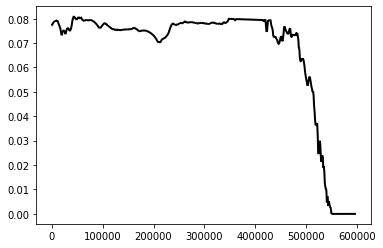

In [44]:
# Make a friction coefficient according to Weertman Sliding Law (could not figure out how to take average value so just chose one)
from firedrake import Constant, sqrt, inner, grad, dx
from icepack.constants import (
    weertman_sliding_law as m,
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)

δs_δx = (s_out - s_in) / Lx
τ_D = -ρ_I * g * h_in * δs_δx

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I
ϕb = firedrake.max_value(1 - p_W / (p_I*0.9),0)

expr = firedrake.interpolate(ϕ * (0.95 - 0.05 * x / Lx) * τ_D / u_in ** (1 / m), Q)
C_0 = firedrake.interpolate(firedrake.assemble(expr,dx),Q)
firedrake.plot(icepack.depth_average(firedrake.interpolate(C_0,Q)))

In [ ]:
### Choose the average C_0 to scale by theta
C_0=firedrake.Constant(0.4)

Parameterize friction in terms of exp(θ)

In [32]:
import icepack.models.hybrid

def friction(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    s = kwargs['surface']
    θ = kwargs['log_friction']
    
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    ϕb = firedrake.max_value(1 - p_W / (p_I*0.85),0)
    
    C = firedrake.exp(θ) * ϕb * C_0
    #C = firedrake.exp(θ) * ϕ * C_0
    return icepack.models.friction.bed_friction(velocity=u, friction=C)

### Define Model

In [33]:
model = icepack.models.HybridModel(friction=friction)
degree = 4
opts = {
    "dirichlet_ids": [1],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

In [34]:
θ = firedrake.Function(Q)

In [35]:
### Initial model velocity
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    log_friction=θ
)

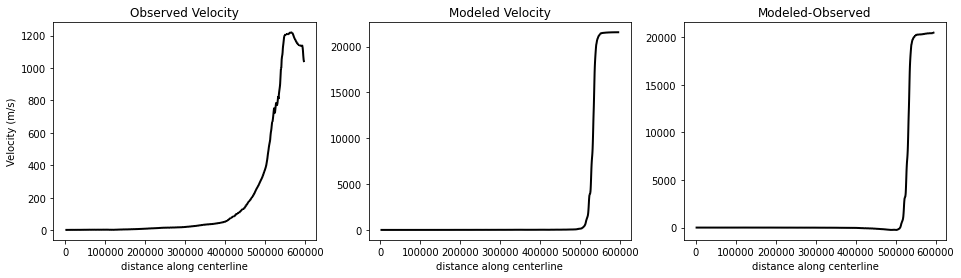

In [36]:
def u_difference_plot(u0,u):
    fig,ax = plt.subplots(1,3,figsize=(16,4))
    firedrake.plot(icepack.depth_average(u0),axes=ax[0])
    firedrake.plot(icepack.depth_average(u),axes=ax[1])
    firedrake.plot(icepack.depth_average(firedrake.interpolate(u-u0,V)),axes=ax[2])
    
    ax[0].set_ylabel('Velocity (m/s)')
    ax[0].set_title('Observed Velocity')
    ax[1].set_title('Modeled Velocity')
    ax[2].set_title('Modeled-Observed')
    
    ax[0].set_xlabel('distance along centerline')
    ax[1].set_xlabel('distance along centerline')
    ax[2].set_xlabel('distance along centerline')
    
    return fig,ax
    
u_difference_plot(u0,u);

### Define Problem
Define the simulation, loss functional, and the regularization functional for the `StatisticsProblem`

In [37]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0,
        thickness=h0,
        surface=s0,
        fluidity=A,
        log_friction=θ,
    )

σx = Constant(5.0)
def loss_functional(u):
    δu = u - u0
    return 0.5 / Lx * (δu / σx)**2 * dx

L = Constant(10e3)
def regularization(θ):
    return 0.5 * L**2 / Lx * inner(grad(θ), grad(θ)) * dx

In [38]:
from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

### Solve
Solve the `StatisticsProblem` using `MaximumProbabilityEstimator` from icepack

In [39]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=400,
    verbose = 0
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     8.675296e+05   1.697201e+04                  5.793768e+01   
  1     2.786609e+05   6.764218e+03   5.793768e+01   1.448442e+02   3         2         0         2         2         
  2     7.351557e+04   4.173324e+02   1.448442e+02   1.448442e+02   4         3         0         2         2         
  3     3.514064e+04   2.013703e+02   1.448442e+02   3.621105e+02   5         4         0         2         2         
  4     3.514064e+04   2.013703e+02   3.621105e+02   2.263191e+01   6         4         2         1         2         
  5     3.054426e+04   1.989823e+02   2.263191e+01   5.657977e+01   7         5         0         1         2         
  6     2.498449e+04   2.558476e+01   5.657977e+01   5.657977e+01   8         6         0         1         3         
  7     2.400778e+04   1.236299e+01   5.657977e+01   1.414494e+0

## Analysis

In [ ]:
import NDH_Tools as ndh

In [40]:
u_fin = simulation(θ)
δu = firedrake.interpolate(u_fin - u0, Q)

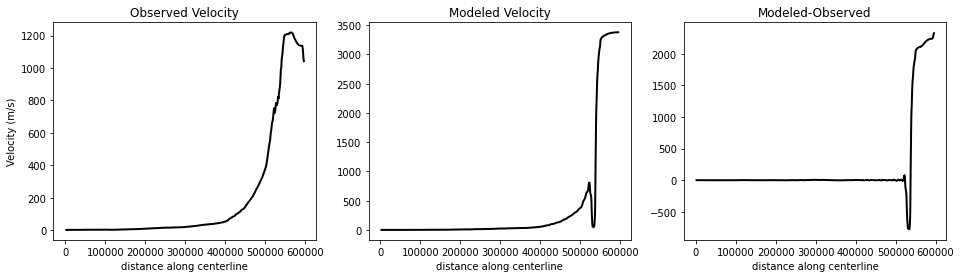

In [41]:
fig,ax = u_difference_plot(u0,u_fin)

In [42]:
friction = firedrake.interpolate(C_0*firedrake.exp(θ),Q)

Text(0.5, 1.0, 'Friction')

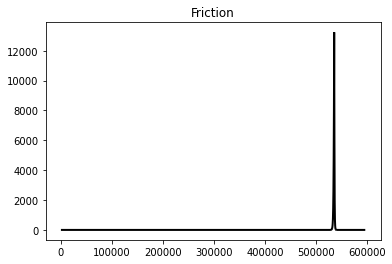

In [43]:
firedrake.plot(icepack.depth_average(friction));
plt.title('Friction')

In [75]:
from firedrake.checkpointing import DumbCheckpoint

filename = "Petermann_xzflowline_friction"

C = firedrake.interpolate(C_0 * firedrake.exp(θ), Q)
if not os.path.exists(filename+'.h5'):
    with firedrake.DumbCheckpoint(filename, "w") as chk:
        chk.store(function=θ,name="log_friction")
        chk.store(function=C,name="friction")

In [ ]:
filename = 'Petermann_xzflowline_friction'
with firedrake.DumbCheckpoint(filename, "r") as chk:
    chk.load(CC, name="friction")